# Defect Thermodynamics

The theromodynamics of the defect creation is such that the current simulation conditionas are nowhere near a steady-state, with the temperatuee having an exponential rise. This is likely a result of the continued effects the removal of the moleucles has had on the cyrsatl structure. What I would like to investigate is whether theres is a set of conditions such that I no longer see this exponential rise in temperature.

In [15]:
# Import required modules
from sdrun.initialise import initialise_snapshot, init_from_crystal 
from sdrun.simulation import production, equilibrate
from sdrun.params import SimulationParams as RunParams
from sdrun.crystals import TrimerP2
from sdanalysis.figures import configuration
from sdanalysis.frame import HoomdFrame

import numpy as np
import pandas
from hoomd.data import make_snapshot
import hoomd
import altair as alt

from bokeh.plotting import show, output_notebook
from bokeh.layouts import gridplot
output_notebook()

Loading BokehJS ...

In [8]:
def remove_molecule(snapshot, index: int):
    """Remove an arbitratry molecule from the simulation.
    
    This also ensures a valid configuration once the molecule has been removed.
    """
    mask = snapshot.particles.body != index
    if sum(mask) == snapshot.particles.N:
        print("Index not in snapshot")
        return snapshot
    new_snapshot = make_snapshot(snapshot.particles.N - 3, snapshot.box, snapshot.particles.types, snapshot.pairs.types)
    for attr in ["position", "orientation", "acceleration", "image", "mass", "moment_inertia", "typeid"]:
        getattr(new_snapshot.particles, attr)[:] = getattr(snapshot.particles, attr)[mask]
    body_mask = snapshot.particles.body != max(snapshot.particles.body)
    new_snapshot.particles.body[:] = snapshot.particles.body[body_mask]
    return new_snapshot

def central_molecule() -> int:
    """Find the molecule closest to the center of the simulation.
    
    This finds the unit cell halfway along each of the axes, then multiplies 
    by 2 since there are 2 molecules in each unit cell.
    
    """
    x, y, z = run_params.cell_dimensions
    return int(x/2 * y + y/2) * 2

def remove_vertical(snapshot, num_mols):
    center = central_molecule()
    for index in range(center-2*int(num_mols/2), center):
        snapshot = remove_molecule(snapshot, index)
    return snapshot

def remove_horizontal(snapshot, num_mols):
    center = central_molecule()
    x, y, x = run_params.cell_dimensions
    extent = 2*int(num_mols/2)*y
    
    for index in range(center-extent, center+extent, (y-1)*2):
        snapshot = remove_molecule(snapshot, index)
        snapshot = remove_molecule(snapshot, index+2)
    return snapshot

def _plot_snapshot(snapshot):
    """Helper function to plot a single snapshot."""
    return configuration.plot_frame(HoomdFrame(snapshot))

def plot_snapshots(snapshots, num_rows=2):
    # Length of sides to make a square
    num_columns = int(len(snapshots)/num_rows)
    figures = []
    for i in range(num_rows):
        row = []
        for j in range(num_columns):
            if i*num_columns + j > len(snapshots):
                figures.append(row)
                return gridplot(figures)
            fig = _plot_snapshot(snapshots[i*num_columns + j])
            fig.plot_height = int(fig.plot_height/num_rows)
            fig.plot_width = int(fig.plot_width/num_rows)
            row.append(fig)
        figures.append(row)
    return gridplot(figures)
            

In [44]:
run_params = RunParams(
    init_temp=0.36,
    temperature=0.36,
    pressure=1.00,
    crystal=TrimerP2(),
    num_steps=1000,
    cell_dimensions=(30, 42, 1),
    hoomd_args='--notice-level=0',
)

In [50]:
# Create a crystal structure
init_snapshot = init_from_crystal(run_params)
vert_snapshot = remove_vertical(init_snapshot, 21)

In [76]:
with run_params.temp_context(tau=100, tauP=10, num_steps=80_000):
    vert_snapshot0 = equilibrate(vert_snapshot, run_params, "crystal")

In [77]:
thermo = pandas.read_csv("./equil-Trimer-P1.00-T0.36.log", sep='\t')
thermo.drop_duplicates('timestep', keep="last", inplace=True)

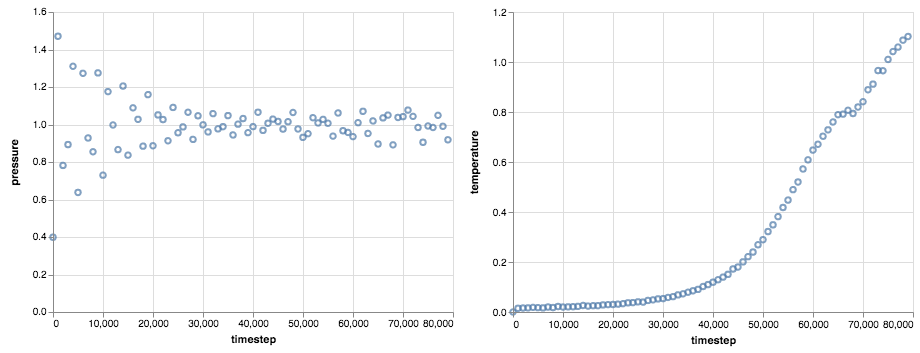

In [78]:
c = alt.Chart(thermo).mark_point().encode(
    x='timestep',
) 
c.encode(y='pressure') | c.encode(y="temperature")

In [79]:
show(_plot_snapshot(vert_snapshot0))